<a href="https://colab.research.google.com/github/tiandrefreitas/desafio_codenation/blob/master/Enem_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importar as bibliotecas a serem usadas
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Leitura dos datasets de treino e teste e criação do df de resposta
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_resposta = pd.DataFrame()

In [5]:
# Verificar se os dados de teste estão nos dados de treinamento
print(set(df_test.columns).issubset(set(df_train.columns)))

True


In [0]:
# Salvar os dados das inscrições
df_resposta['NU_INSCRICAO'] = df_test['NU_INSCRICAO']

In [0]:
# Selecionar somente valores inteiros e floats
df_test = df_test.select_dtypes(include=['int64','float64'])

In [8]:
var = ['NU_IDADE','IN_TREINEIRO','NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']
df_test[var].corr()

,NU_IDADE,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO
NU_IDADE,1.000000,-0.293714,-0.105278,-0.048229,-0.079171,-0.161202
IN_TREINEIRO,-0.293714,1.000000,-0.009669,-0.032181,-0.004934,-0.014277
NU_NOTA_CN,-0.105278,-0.009669,1.000000,0.598574,0.545801,0.442692
NU_NOTA_CH,-0.048229,-0.032181,0.598574,1.000000,0.679993,0.537141
NU_NOTA_LC,-0.079171,-0.004934,0.545801,0.679993,1.000000,0.495745
NU_NOTA_REDACAO,-0.161202,-0.014277,0.442692,0.537141,0.495745,1.000000


In [0]:
features = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']

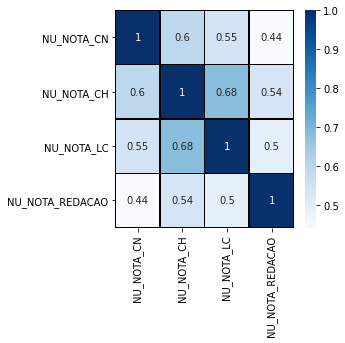

In [13]:
%matplotlib inline

plt.figure(figsize=(4,4))
sns.heatmap(df_test[features].corr(), annot=True,linewidths=0.5,linecolor='black',cmap='Blues')
plt.xticks(rotation=90)
plt.show()

In [0]:
# Usando o loc com uma condição composta para obter somente registros com todas as provas
df_train = df_train.loc[(df_train['NU_NOTA_CN'].notnull()) & (df_train['NU_NOTA_CH'].notnull())  & (df_train['NU_NOTA_LC'].notnull()) & (df_train['NU_NOTA_REDACAO'].notnull()) & (df_train['NU_NOTA_MT'].notnull())]

In [15]:
df_test[features].isnull().sum()

NU_NOTA_CN         1134
NU_NOTA_CH         1134
NU_NOTA_LC         1199
NU_NOTA_REDACAO    1199
dtype: int64

In [0]:
# Preencher valores nulos com o valor médio - Tratamento das notas de provas corrompidas
df_train['NU_NOTA_CN'].fillna(df_train['NU_NOTA_CN'].mean(), inplace=True)
df_train['NU_NOTA_CH'].fillna(df_train['NU_NOTA_CH'].mean(), inplace=True)
df_train['NU_NOTA_REDACAO'].fillna(df_train['NU_NOTA_REDACAO'].mean(), inplace=True)
df_train['NU_NOTA_LC'].fillna(df_train['NU_NOTA_LC'].mean(), inplace=True)
df_test['NU_NOTA_CN'].fillna(df_train['NU_NOTA_CN'].mean(), inplace=True)
df_test['NU_NOTA_CH'].fillna(df_train['NU_NOTA_CH'].mean(), inplace=True)
df_test['NU_NOTA_REDACAO'].fillna(df_train['NU_NOTA_REDACAO'].mean(), inplace=True)
df_test['NU_NOTA_LC'].fillna(df_train['NU_NOTA_LC'].mean(), inplace=True)

In [0]:
y = df_train['NU_NOTA_MT']

In [0]:
# Definição do dataset de treino somente com as informações relevantes para treinar o modelo
features = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']
x_train = df_train[features]

In [0]:
# Ajustando o Transformer API
scaler = preprocessing.StandardScaler().fit(x_train)

In [21]:
X_train_scaled = scaler.transform(x_train)
print('Média: {}'.format(X_train_scaled.mean(axis=1)))
print('Desvio Padrão: {}'.format(X_train_scaled.std(axis=0)))

Média: [-0.03069405  0.43165148 -0.17994011 ...  0.25471651  0.20825568
  0.3693551 ]
Desvio Padrão: [1. 1. 1. 1.]


In [0]:
x_test = df_test[features]

In [0]:
#n_estimators=100 (número de nós) , n_jobs=-1 ( todo o processamento possível) , warm_start=True (mantém o aprendizado e reprocessa o modelo, melhorando-o)
pipeline = make_pipeline(preprocessing.StandardScaler(), RandomForestRegressor(n_estimators=200, n_jobs=-1, warm_start=True))


In [0]:
# max_features : O número de features a considerar quando pesquisar pela melhor separação (testará as 3 opções e identificará a melhor para o modelo)
# max_depth :  Profundidade máxima da árvore de decisão. Se None (nenhuma), os nós serão expandidos até acabar as folhas ou até que elas contenham o mínimo valor de amostras possível.
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [26]:
# Ajustar e sintonizar o modelo
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(X_train_scaled, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                            

In [27]:
print(clf.best_params_)

{'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'log2'}


In [0]:
pred_notas = clf.predict(x_test)

In [0]:
df_resposta['NU_NOTA_MT'] = np.around(pred_notas,2)

In [30]:
df_resposta['NU_NOTA_MT'].unique()

array([808.99, 800.16, 481.76, 752.87, 755.31, 545.66])

In [0]:
df_resposta.to_csv('answer.csv', index=False, header=True)

In [32]:
# Salvar o modelo preditivo
joblib.dump(clf, 'rf_regressor.pkl')

['rf_regressor.pkl']